Found 9957 files belonging to 4 classes.


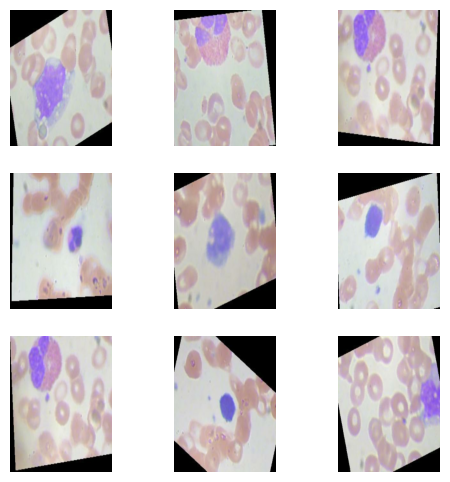

In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Parametry
IMG_SIZE = (320, 240)
BATCH_SIZE = 32
DATA_DIR = "images/TRAIN"

# Wczytanie zbioru treningowego
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'  # Bo mamy więcej niż 2 klasy
)

# Podział na trening/validację
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset = train_dataset.take(train_size)
val_dataset = train_dataset.skip(train_size)

# Normalizacja wartości pikseli do [0,1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

# Podgląd danych
plt.figure(figsize=(6,6))
for images, labels in train_dataset.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy())
        plt.axis("off")
    plt.show()


## 🧠 Budowa modelu CNN do klasyfikacji komórek krwi

Teraz stworzymy **konwolucyjny model sieci neuronowej (CNN)**, który nauczy się rozpoznawać typy komórek na podstawie zdjęć.  
Model składa się z kilku warstw:

1. **Warstwy konwolucyjne (`Conv2D`)** – wykrywają wzorce na obrazach, np. kształty komórek.  
2. **Warstwy `MaxPooling2D`** – zmniejszają rozmiar obrazu, aby uprościć obliczenia.  
3. **Warstwa `Flatten`** – przekształca obraz w wektor cech.  
4. **Warstwa gęsta (`Dense`)** – uczy się rozpoznawać kategorie komórek.  
5. **Warstwa wyjściowa (`Dense(4, activation='softmax')`)** – zwraca prawdopodobieństwa dla 4 klas.  

Funkcja aktywacji **ReLU** przyspiesza uczenie, a **Dropout (0.5)** zapobiega przeuczeniu modelu.  


In [17]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(320, 240, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    # layers.Conv2D(128, (3,3), activation='relu'),
    # layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),    #128
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # 4 klasy
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 318, 238, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 159, 119, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 157, 117, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 78, 58, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 289536)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │    18,530,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,550,020 (70.76 MB)

 Trainable params: 18,550,020 (70.76 MB)

 Non-trainable params: 0 (0.00 B)

## 🚀 Trenowanie modelu na danych komórek krwi

Model zostanie nauczony na zbiorze treningowym przez 20 epok.  
Podczas każdej epoki:
- Model przeanalizuje dane i dostosuje swoje wagi.
- Sprawdzimy jego skuteczność na zbiorze walidacyjnym.

Na koniec zapisujemy wytrenowany model (`.h5`), aby później można było go załadować i użyć do klasyfikacji nowych zdjęć.  


In [18]:
EPOCHS = 20
# train_dataset = train_dataset.repeat()

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    steps_per_epoch=len(train_dataset)
)

# Zapisanie modelu
model.save("blood_cell_classifier.h5")


Epoch 1/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 207s 825ms/step - accuracy: 0.2467 - loss: 2.8890
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 262s 824ms/step - accuracy: 0.2506 - loss: 1.3856
Epoch 3/20


2025-02-23 22:12:29.011344: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


249/249 ━━━━━━━━━━━━━━━━━━━━ 203s 814ms/step - accuracy: 0.2717 - loss: 1.3813
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 195s 781ms/step - accuracy: 0.3035 - loss: 1.3705
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 195s 781ms/step - accuracy: 0.3284 - loss: 1.3495
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 195s 781ms/step - accuracy: 0.3597 - loss: 1.3127
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 195s 781ms/step - accuracy: 0.4114 - loss: 1.2567
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 195s 782ms/step - accuracy: 0.4597 - loss: 1.1845
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 211s 817ms/step - accuracy: 0.5089 - loss: 1.1066
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 248s 995ms/step - accuracy: 0.5532 - loss: 1.0241
Epoch 11/20


2025-02-23 22:39:43.075084: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


249/249 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.5854 - loss: 0.9408 
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 268s 837ms/step - accuracy: 0.6307 - loss: 0.8661
Epoch 13/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.6672 - loss: 0.7957 
Epoch 14/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 229s 919ms/step - accuracy: 0.6935 - loss: 0.7120
Epoch 15/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.7049 - loss: 0.6847
Epoch 16/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 291s 953ms/step - accuracy: 0.7391 - loss: 0.6088
Epoch 17/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 262s 952ms/step - accuracy: 0.7437 - loss: 0.6052
Epoch 18/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.7590 - loss: 0.5504 
Epoch 19/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 225s 903ms/step - accuracy: 0.7652 - loss: 0.5307
Epoch 20/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 223s 895ms/step - accuracy: 0.7786 - loss: 0.5085
